In [47]:
%pip install -U google-generativeai
%pip install google-ai-generativelanguage==0.6.15
%pip install -U langchain-google-genai
%pip install -U langchain-community
%pip install -U langchain
%pip install -U langgraph langchain-community
%pip install python-dotenv
%pip install -U langchain-tavily

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator

import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.messages import BaseMessage

from langchain_community.tools.tavily_search import TavilySearchResults

In [49]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['GOOGLE_API_KEY'] = os.getenv('GEMINI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [50]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [51]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print(f"\n bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}


In [53]:
prompt = """Você é um assistente de pesquisa inteligente. Use o mecanismo de busca para procurar informações. \
Você tem permissão para fazer múltiplas chamadas (seja em conjunto ou em sequência). \
Procure informações apenas quando tiver certeza do que você quer. \
Se precisar pesquisar alguma informação antes de fazer uma pergunta de acompanhamento, você tem permissão para fazer isso!
"""
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
abot = Agent(model, [tool], system=prompt)

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [54]:
mermaid_code = abot.graph.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	llm(llm)
	action(action)
	__end__([<p>__end__</p>]):::last
	__start__ --> llm;
	action --> llm;
	llm -. &nbsp;False&nbsp; .-> __end__;
	llm -. &nbsp;True&nbsp; .-> action;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



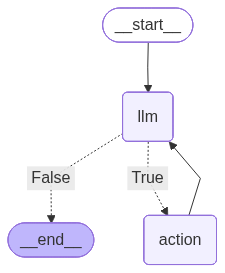

In [55]:
from IPython.display import Image, display

try:
    image_data = abot.graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))
except Exception as e:
    print(f"Erro ao tentar gerar PNG do Mermaid: {e}")
    print("\nCertifique-se de que a sua versão do LangGraph possui o método `.draw_mermaid_png()`.")
    print("Como alternativa, use `.draw_mermaid()` para obter a string e visualizar externamente.")

In [56]:
%pip install tavily-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI

tool_instance = TavilySearchResults(max_results=4)

abot = Agent(model, [tool_instance], system=prompt)

messages = [
    HumanMessage(content="Como está o tempo em São Paulo hoje?")
]

def extract_text(msg):
    if isinstance(msg, AIMessage):
        content = msg.content
        if isinstance(content, list):
            return content[0].get("text", "")
        return content
    return str(msg)

print("Iniciando interação do agente:")
final_result_state = None

for s in abot.graph.stream({"messages": messages}):
    final_result_state = s

print("\nResultado Final:")
if final_result_state and 'llm' in final_result_state:
    last_msg = final_result_state['llm']['messages'][-1]
    print(extract_text(last_msg.content[0]["text"]))
else:
    print("Nenhum resultado final.")


Iniciando interação do agente:
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo em São Paulo hoje'}, 'id': '4dd246e1-ca6b-405b-b55c-c5249be40639', 'type': 'tool_call'}
Back to the model!

Resultado Final:
Em São Paulo, hoje, terça-feira, o céu estará nublado com possibilidade de garoa pela manhã. À tarde o sol aparece, e há previsão de pancadas de chuva à tarde e à noite. A temperatura máxima será de 22°C e a mínima de 16°C. A probabilidade de chuva é de 97% (4mm), com ventos de 17km/h (SSE) e umidade entre 65% e 92%.


In [75]:
user_query_tomorrow = "Como estará o tempo em São Paulo amanhã?" #atualizamos apenas a pergunta do usuário

messages_tomorrow = [HumanMessage(content=user_query_tomorrow)]

print("\n--- Iniciando interação do agente para amanhã ---")
final_result_state_tomorrow = None
for s in abot.graph.stream({"messages": messages_tomorrow}):
    final_result_state_tomorrow = s

print("\n--- Resultado Final para amanhã ---")
if final_result_state_tomorrow and 'llm' in final_result_state_tomorrow and final_result_state_tomorrow['llm']['messages']:
    last_msg = final_result_state_tomorrow['llm']['messages'][-1]
    print(last_msg.content[0]["text"])

else:
    print("Nenhum resultado final ou resultado inesperado para amanhã.")


--- Iniciando interação do agente para amanhã ---
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'previsão do tempo São Paulo amanhã'}, 'id': 'ec7cf6aa-8d2b-4834-846d-841b11d11ca0', 'type': 'tool_call'}
Back to the model!

--- Resultado Final para amanhã ---
A previsão do tempo para São Paulo amanhã indica um dia com sol e algumas nuvens, mas com alta probabilidade de chuva. As temperaturas devem variar entre 19°C e 30°C.

Detalhes:
*   **Temperaturas:** Mínima em torno de 19°C a 21°C e máxima entre 26°C e 30°C.
*   **Céu:** Sol com algumas nuvens ou sol com muitas nuvens.
*   **Chuva:** Há uma alta probabilidade de chuva (entre 89% e 98%), com pancadas de chuva rápidas durante o dia e à noite, ou chuvas moderadas, especialmente no período da tarde e noite.
*   **Vento:** Leve a moderado, com rajadas que podem chegar a 28 km/h.


In [78]:
messages = [HumanMessage(content="Como está o tempo em São Paulo e no Rio de Janeiro hoje?")]
result = abot.graph.invoke({"messages": messages})

result
result['messages'][-1].content[0]["text"]

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo em São Paulo hoje'}, 'id': 'f00396a6-fee1-48f5-bc99-e46e2ef00c28', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo no Rio de Janeiro hoje'}, 'id': '8f851979-b092-47f3-9e7a-afb23abdefc2', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo em São Paulo hoje'}, 'id': '634c1825-4b0f-4a19-b4fc-dc3b563a7bac', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo em São Paulo hoje 3 de fevereiro de 2024'}, 'id': 'e8fb410e-64c1-4939-ad88-6969859856ac', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo no Rio de Janeiro hoje 3 de fevereiro de 2024'}, 'id': '4614f3fa-7541-4f0f-a612-6b02997664c0', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'previsão do tem

'Em São Paulo, hoje, 3 de fevereiro de 2024 (sábado), haverá períodos de sol com chuva isolada na madrugada e noite. A nebulosidade aumentará e a chuva é esperada a partir da tarde, especialmente no final da tarde e noite, com chance de trovoada isolada. As temperaturas máximas ficarão entre 29°C e 33°C.\n\nNo Rio de Janeiro, hoje, 3 de fevereiro de 2024 (sábado), a temperatura máxima será de 33°C e a mínima de 22°C, com umidade variando entre 50% e 100%. O tempo estará abafado, com muita variação de nebulosidade e chuvas frequentes.'

In [66]:
query_passado = "Qual país sediou a Copa do Mundo de futebol em 1998? Quem foi o campeão e qual o placar da final? \
Qual era o Produto Interno Bruto (PIB) desse país no ano da Copa e qual é o PIB atual (últimos dados disponíveis, como 2023 ou 2024) \
Qual a capital desse país e qual sua moeda atual? Responda a cada pergunta separadamente."
messages = [HumanMessage(content=query_passado)]

In [79]:
print("\n--- Agente de Pesquisa Interativo ---")
print("Digite sua pergunta ou 'sair' para encerrar.")

while True:
    user_input = input("\nVocê: ")
    if user_input.lower() == "sair":
        print("Agente: Encerrando a conversa. Até logo!")
        break
    
    messages = [HumanMessage(content=user_input)]

    print("Agente: Pensando e buscando...")
    final_result_state = None
    try:
        current_state = {}
        for s in abot.graph.stream({"messages": messages}):
            current_state.update(s)
        
        print("\nAgente:")
        if 'llm' in current_state and 'messages' in current_state['llm'] and current_state['llm']['messages']:
            final_message = current_state['llm']['messages'][-1]
            if hasattr(final_message, 'content'):
                print(final_message.content[0]["text"])
            else:
                print("Não foi possível extrair o conteúdo da resposta final do LLM.")
        else:
            print("Não foi possível obter uma resposta do agente para esta pergunta.")

    except Exception as e:
        print(f"Agente: Ocorreu um erro durante a execução: {e}")
        print("Tente novamente ou digite 'sair'.")

print("\n--- Conversa Encerrada ---")


--- Agente de Pesquisa Interativo ---
Digite sua pergunta ou 'sair' para encerrar.
Agente: Pensando e buscando...
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tempo em brasilia'}, 'id': 'cfac3ed4-7407-47de-b5a6-7957e9bce13f', 'type': 'tool_call'}
Back to the model!

Agente:
Em Brasília, hoje (10 de fevereiro), a previsão é de temperaturas entre 18°C e 25°C, com 80% de chance de 3.5 mm de chuva e ventos de 19 a 44 km/h.

No momento (por volta das 17h), a temperatura é de 21°C com sensação térmica de 21°C, há 50% de chance de chuva fraca (0.5 mm) e o vento é do Noroeste entre 10 e 41 km/h.

Mais tarde, por volta das 19h, a temperatura será de 21°C, com céu nublado e ventos do Noroeste entre 6 e 22 km/h. À meia-noite, a temperatura deve ser de 19°C, com céu nublado e ventos do Norte entre 3 e 8 km/h.
Agente: Pensando e buscando...
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'como estão as bolsas do mundo'}, 'id': '643c4b94-a6d5-46ad-be1e-0d0027